In [1]:
from openimages.download import download_dataset
download_dataset("./dest/dir", ["Cat",], annotation_format="pascal", limit=5)

2024-11-09  22:56:02 INFO Downloading 5 train images for class 'cat'
100%|█████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 13.49it/s]
2024-11-09  22:56:03 INFO Creating 5 train annotations (pascal) for class 'cat'
100%|████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 471.38it/s]


{'cat': {'images_dir': './dest/dir/cat/images',
  'annotations_dir': './dest/dir/cat/pascal'}}

In [2]:
import xml.etree.ElementTree as ET
from pathlib import Path

# Define the path where your annotations are stored
annotations_path = Path("./dest/dir/car/pascal")
images_path = Path("./dest/dir/car/images")

# Function to parse the XML and get bounding boxes
def parse_anno(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()

    bboxes = []
    for obj in root.findall("object"):
        class_name = obj.find("name").text
        bbox = obj.find("bndbox")
        width = int(root.find("size/width").text)
        height = int(root.find("size/height").text)
        x_min = int(bbox.find("xmin").text)
        y_min = int(bbox.find("ymin").text)
        x_max = int(bbox.find("xmax").text)
        y_max = int(bbox.find("ymax").text)
        bboxes.append([x_min, y_min, x_max, y_max])

    return width, height, min(bboxes)

In [3]:
'''
get overlap percentage
'''
def overlap_ratio(occluder_bb, occludee_bb):

    #top left and bottom right points
    occluder_x1, occluder_y1, occluder_x2, occluder_y2 = occluder_bb
    occludee_x1, occludee_y1, occludee_x2, occludee_y2 = occludee_bb

    # area of the foreground object
    occludee_area = (occludee_x2 - occludee_x1) * (occludee_y2 - occludee_y1)

    # area of the background object being covered by the foreground object
    overlap_area = max(0, min(occludee_x2, occluder_x2) - max(occludee_x1, occluder_x1)) * max(0, min(occludee_y2, occluder_y2) - max(occludee_y1, occluder_y1))

    # overlap over the total background object area
    return overlap_area / occludee_area

In [4]:
import random

'''
Get a list of randomly chosen bounding boxes to occlude the background object above some threshold
This can be improved if we know the foreground image has to be some base scale to allow for above threshold occlusion
'''
def get_bbox_list(bg_bbox, bg_w, bg_h, fg_w, fg_h):

    bboxes = []

    occludee_x1 = bg_bbox[0]
    occludee_y1 = bg_bbox[1] 
    occludee_x2 = bg_bbox[2]
    occludee_y2 = bg_bbox[3]

    num_boxes = 5 # iterate over multiple boxes
    overlap_threshold = .2 # ensure a minimum amount of overlap

    # print(bg_bbox, fg_w, fg_h)
    
    for _ in range(num_boxes):
        # top left corner of the occluder bounding box:

        occluder_x1 = random.randint(max(0, occludee_x1 - fg_w), occludee_x2) # overlapping in the x-direction
        occluder_y1 = random.randint(max(0, occludee_y1 - fg_h), occludee_y2) # overlapping in the y-direction

        # TODO: Fix so doesnt exceed background image
        
        occluder_x2 = occluder_x1 + fg_w
        occluder_y2 = occluder_y1 + fg_h

        # Maybe this will fix sizing error??? (IT DOES)
        if occluder_x2 > bg_w or occluder_y2 > bg_h:
            continue

        occluder_bb = [occluder_x1, occluder_y1, occluder_x2, occluder_y2]
        occluded_ratio = overlap_ratio(occluder_bb, bg_bbox)

        if occluded_ratio >= overlap_threshold:
            bboxes.append([occluder_x1, occluder_y1, occluder_x2, occluder_y2])
    
    return bboxes

In [7]:
'''
returns the score, composite image, and compositive mask. 
num scales is the number of different foreground scales to try.
'''
from libcom import OPAScoreModel

def get_optimal_location(fg_img, fg_mask, bg_img, bg_w, bg_h, bg_bbox, num_scales):

    net = OPAScoreModel(device=0, model_type='SimOPA')
    cache_dir = './cache'

    # from libcom.fopa_heat_map.source.prepare_multi_fg_scales import prepare_multi_fg_scales
    scaled_fg_dir, scaled_mask_dir, csv_path = prepare_multi_fg_scales(cache_dir, fg_img, fg_mask, bg_img, num_scales)

    score = 0
    optimal_bbox = None
    best_fg = None
    best_mask = None
    best_comp = None 
    best_comp_mask = None
    
    # iterate over the different foreground scales
    with open(csv_path, mode='r', newline='') as csv_file:
        csv_reader = csv.DictReader(csv_file)
        for row in csv_reader:
            fg_name   = '{}_{}_{}_{}.jpg'.format(row["fg_name"].split(".")[0],row["bg_name"].split(".")[0],int(row["newWidth"]),int(row["newHeight"]))
            mask_name = '{}_{}_{}_{}.jpg'.format(row["fg_name"].split(".")[0],row["bg_name"].split(".")[0],int(row["newWidth"]),int(row["newHeight"]))
            scale     = row['scale']
            fg_w = int(row['newWidth'])
            fg_h = int(row['newHeight'])
            
            save_name = fg_name.split(".")[0] + '_' + str(scale) + '.jpg'
            bg_img    = read_image_pil(bg_img)
            fg_img    = read_image_pil(os.path.join(scaled_fg_dir, fg_name))
            fg_mask   = read_mask_pil(os.path.join(scaled_mask_dir, mask_name))
            bbox_list = get_bbox_list(bg_bbox, bg_w, bg_h, fg_w, fg_h)
    
            for bbox in bbox_list:
                comp, comp_mask = get_composite_image(fg_img, fg_mask, bg_img, bbox)
                bbox_score = net(comp, comp_mask)
                if bbox_score > score:
                    best_fg = os.path.join(scaled_fg_dir, fg_name)
                    best_mask = os.path.join(scaled_mask_dir, mask_name)
                    optimal_bbox = bbox
                    best_comp = comp
                    best_comp_mask = comp_mask
                    score = bbox_score

        return score, best_fg, best_mask, optimal_bbox, best_comp, best_comp_mask

In [13]:
'''
Right now this just takes does one specific foreground image (teddy bear), and one background image (skier)
'''
from libcom import color_transfer
from libcom.utils.process_image import *
from libcom.utils.environment import *
from libcom import OPAScoreModel
from libcom import get_composite_image
from libcom.utils.process_image import make_image_grid
import cv2
import csv
from PIL import Image
from libcom.fopa_heat_map.source.prepare_multi_fg_scales import prepare_multi_fg_scales
from libcom import ImageHarmonizationModel
from libcom import Mure_ObjectStitchModel

from libcom import ControlComModel

net = OPAScoreModel(device=0, model_type='SimOPA')

# for each scale, take the highest OPA score
fg_scale_num = 16

# trying with just one foreground image (teddy bear) and one background image (skier)
foreground_image = '../workspace/libcom/tests/source/foreground/1.jpg'
foreground_mask = '../workspace/libcom/tests/source/foreground_mask/1.png'

# Define the path where your annotations are stored
bg_annotations_path = Path("./dest/dir/cat/pascal")
bg_images_path = Path("./dest/dir/cat/images")

CDTNet = ImageHarmonizationModel(device=0, model_type='CDTNet')
net    = Mure_ObjectStitchModel(device=0, sampler='plms')

for annotation_file in bg_annotations_path.glob("*.xml"):
    image_id = annotation_file.stem
    bg_img = os.path.join(bg_images_path, f"{image_id}.jpg")
    bg_w, bg_h, bg_bbox = parse_anno(annotation_file)
    score, fg_img, fg_mask, bbox, comp, comp_mask = get_optimal_location(foreground_image, foreground_mask, bg_img, bg_w, bg_h, bg_bbox, num_scales=16)
    
    if(score):
        # print(fg_img, fg_mask)
        # res = color_transfer(comp, comp_mask)
        # grid_img  = make_image_grid([res])
        # cv2.imwrite(f'./results/composite_color_trans{image_id}.jpg', grid_img)

        # net      = ControlComModel(device=0, model_type="ControlCom")
        # res     = net(bg_img, fg_img, bbox, fg_mask, task=['blending'], guidance_scale=1)
        # res = CDTNet(comp, comp_mask)
        # print(len(comp))
        # print(comp)
        res, show_fg_img = net(bg_img, [fg_img], [fg_mask], bbox, sample_steps=25, num_samples=3)
        
        bg_img   = draw_bbox_on_image(bg_img, bbox)
        grid_img = make_image_grid([bg_img, fg_img, comp, comp_mask, res])
        cv2.imwrite('./results/harm_controlcom_result{}.jpg'.format(image_id), grid_img)

NameError: name 'MureObjectStitchModel' is not defined

In [1]:
from IPython.display import Image

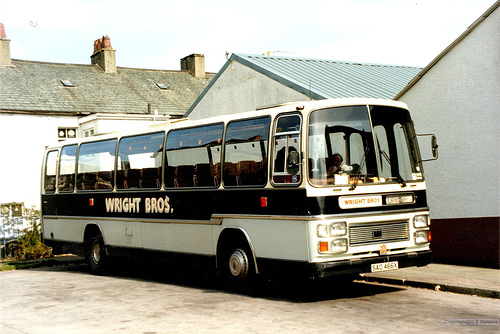

In [3]:
image_path ='/srv/PASCAL3D+_release1.1/Images/bus_imagenet/n03306385_12361.JPEG'

Image(filename=image_path) 

In [11]:
import numpy as np

data = np.load('/srv/occluder_libs_test_small.npz', allow_pickle=True)

In [12]:
print(data)

In [15]:
data['masks'][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

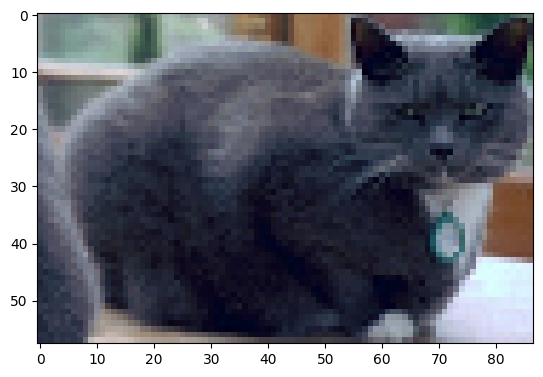

In [17]:
from matplotlib import pyplot as plt
plt.imshow(data['images'][0], interpolation='nearest')
plt.show()